In [ ]:
# **Parameter-Einstellungen**
CSV_FILE = "../data/image_data_rel.csv"
ORIGINAL_IMG_SIZE = (256, 256)  # Originalbildgröße
TARGET_IMG_SIZE = (299, 299)  # Zielgröße nach Resize 299 required by InceptionV3
IMAGES_PER_LABEL = 20  # Anzahl Bilder pro Label
EPOCHS = 20  # Anzahl der Trainings-Epochen
BATCH_SIZE = 20  # Batch-Size fürs Training
VALIDATION_SPLIT = 0.2  # Anteil der Daten für Validierung

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import PIL.Image as Image
import random
import matplotlib.pyplot as plt
from pathlib import Path

# **GPU auswählen**
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 1:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    print("Nutze GPU:", gpus[1])

# **CSV-Datei einlesen**
df = pd.read_csv(CSV_FILE)

# **Labels in numerische Werte umwandeln**
labels = sorted(df["label"].unique())  
label_map = {label: idx for idx, label in enumerate(labels)}

# **Daten vorbereiten**
X = []
y = []

project_root = Path().resolve()

for label in labels:
    images = df[df["label"] == label]["url"].tolist()
    
    # Genau `IMAGES_PER_LABEL` Bilder pro Label auswählen (falls weniger vorhanden, alle nehmen)
    selected_images = random.sample(images, min(len(images), IMAGES_PER_LABEL))
    
    for rel_path in selected_images:
        image_path = project_root / rel_path
        
        try:
            img = Image.open(image_path).convert("RGB")  
            img = img.resize(TARGET_IMG_SIZE)  # **Resize auf 80x80**
            img_array = np.array(img) / 255.0  # Skalierung auf [0,1]
            
            X.append(img_array)
            y.append(label_map[label])  
        
        except Exception as e:
            print(f"Fehler beim Laden von {image_path}: {e}")

# **In NumPy-Arrays umwandeln**
X = np.array(X)
y = np.array(y)

# InceptionV3 (former GoogleNet)

Setup

In [5]:
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# pretrained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=TARGET_IMG_SIZE + (3,))
base_model.trainable = False

# custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(label_map), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

y = to_categorical(y, num_classes=len(label_map))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VALIDATION_SPLIT, stratify=y, random_state=42)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.0770 - loss: 3.2234 - val_accuracy: 0.2667 - val_loss: 2.4229
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.3688 - loss: 2.0393 - val_accuracy: 0.3000 - val_loss: 2.0495
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6780 - loss: 1.3901 - val_accuracy: 0.4167 - val_loss: 1.8476
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.6773 - loss: 1.1529 - val_accuracy: 0.5000 - val_loss: 1.6485
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8039 - loss: 0.8309 - val_accuracy: 0.4500 - val_loss: 1.5665
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8678 - loss: 0.6614 - val_accuracy: 0.5333 - val_loss: 1.5129
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.8970 - loss: 0.5503 - val_accuracy: 0.5833 - val_loss: 1.4527
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9347 - loss: 0.4650 - val_accuracy: 0.

loss

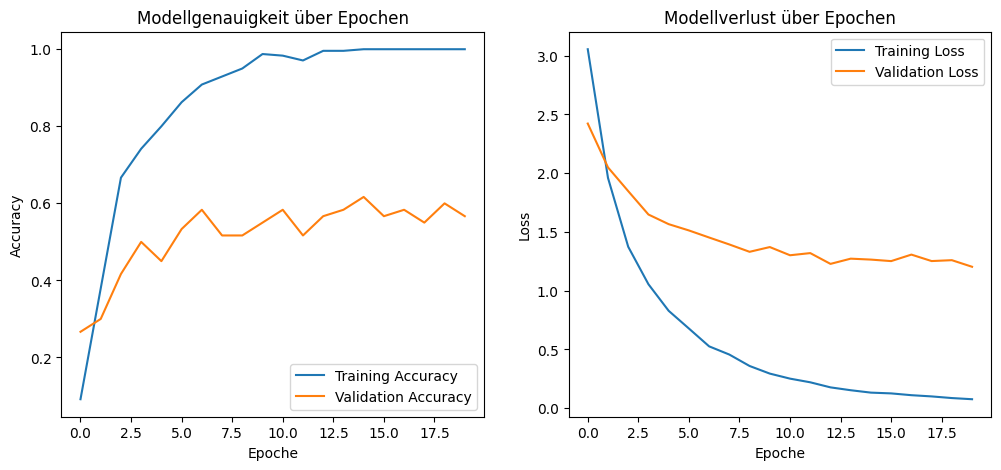

In [6]:
# **Trainingsverlauf visualisieren**
plt.figure(figsize=(12, 5))

# **Genauigkeit (Accuracy)**
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.title("Modellgenauigkeit über Epochen")
plt.legend()

# **Verlust (Loss)**
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.title("Modellverlust über Epochen")
plt.legend()

plt.show()